# Project 5: Getting Started with GANs

### Desrciption of the Problem:
In this notebook, I am going to use the Kaggle dataset "GAN-Getting-Started" to create a model that can take in real-world image and output a monet version of the paining. The key here is train a generator to produce monet style paintings and a discrimiator to determine if it is a monet painting or not. Eventually the generator will produce such high quality monet style images that it will become difficult fo the discriminator to detect. This will be the final model we use to generate these style images. 

### EDA
This dataset contains various images of real-would outdoor scenery as well as different monet paintings of landscapes. There are only 300 monet paintings and 7,000 real world examples so the dataset is unbalanced. Addtionally, I found the images to be sized 256x256. These are large images so I will keep the batches small and the epoch low to make the most of my time, but in a real-world scnario I would look for more resources.


### Model Architecture
After looking into the NIPS 2016 Tutorial: Generative Adversaial Networks, I implemented a GAN to create Monet paintings. This model includes a residual block, a generator model and a discriminator model. The generator has 10 layers plus an addtional 6 residual blocks, and the discriminator has 9 layers. Additionally they both take in an input shape of 256x256.


### Conclusion
I realized after the fact, that we can train the models in Kaggle's notebooks, so the imagages displayed here at the bottom are 32x32 instead of 256x256. However I did redo the code in here to reflect my official submission to Kaggle and I have provided a screenshot in deliverable 3 of the official 256x256 images developed by this model architecture. Overall, I realized how much resources GAN's require, but my images look pretty good for the limited training. I think I could definitley optimize how I'm training the models as well as improve the the model architecture to be more efficient. However, I believe if I had more resources and time this apporach would be able to produce high quality results in the competition. 

## Step 1: Load in the Data and do EDA

In [36]:
!nvidia-smi

Tue Mar  4 03:57:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P0             32W /   70W |     199MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

monet images: 300, photo images: 7038


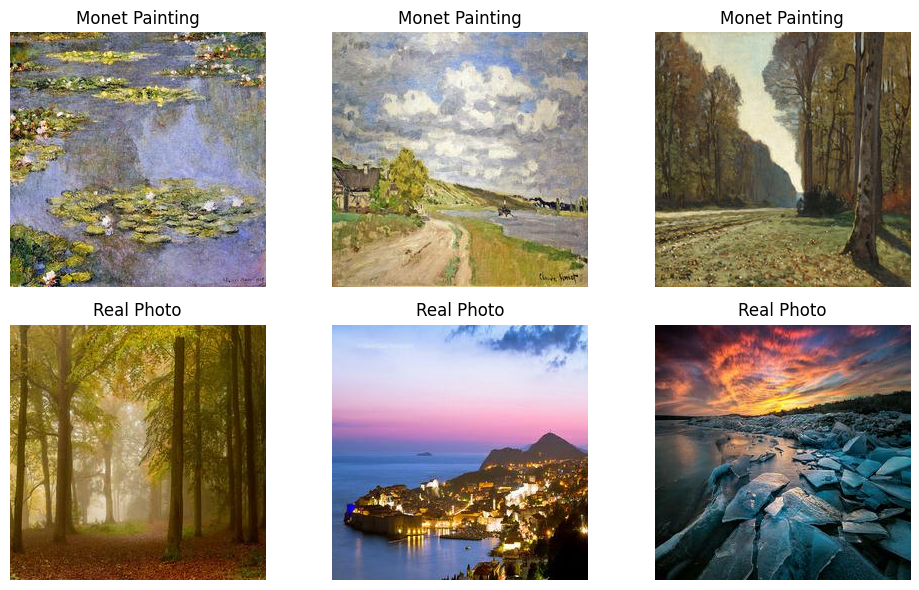

In [37]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob

# load image paths
monet_path = "/kaggle/input/gan-dataset/gan-getting-started/monet_jpg/*.jpg"
photo_path = "/kaggle/input/gan-dataset/gan-getting-started/photo_jpg/*.jpg"

monet_files = glob(monet_path)
photo_files = glob(photo_path)

print(f"monet images: {len(monet_files)}, photo images: {len(photo_files)}")

#plot
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

for i in range(3):
    monet_img = plt.imread(monet_files[i])
    photo_img = plt.imread(photo_files[i])

    axes[0, i].imshow(monet_img)
    axes[0, i].axis("off")
    axes[0, i].set_title("Monet Painting")

    axes[1, i].imshow(photo_img)
    axes[1, i].axis("off")
    axes[1, i].set_title("Real Photo")

plt.tight_layout()
plt.show()


In [38]:
print(f"monet images: {len(monet_files)}")
print(f"photo images: {len(photo_files)}")

monet images: 300
photo images: 7038


In [39]:
from PIL import Image
import random

def check_image_sizes(files, num_samples=10):
    sizes = [Image.open(f).size for f in random.sample(files, num_samples)]
    return sizes

print("monet image sizes:", check_image_sizes(monet_files))
print("photo image sizes:", check_image_sizes(photo_files))


monet image sizes: [(256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256)]
photo image sizes: [(256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256), (256, 256)]


## Step 2: Preprocess the Data

In [ ]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
BUFFER_SIZE = 1000

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = (tf.cast(img, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return img

# preprocess datasets
monet_ds = (tf.data.Dataset.from_tensor_slices(monet_files)
            .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

photo_ds = (tf.data.Dataset.from_tensor_slices(photo_files)
            .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

train_ds = tf.data.Dataset.zip((photo_ds, monet_ds))

In [81]:
for real_photo, real_monet in train_ds.take(1):
    print(f"Photo batch shape: {real_photo.shape}")
    print(f"Monet batch shape: {real_monet.shape}")


Photo batch shape: (8, 32, 32, 3)
Monet batch shape: (8, 32, 32, 3)


## Step 3: Build the GAN

In [ ]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, ReLU, BatchNormalization, Add
from tensorflow.keras.models import Model

def residual_block(x):
    res = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    res = BatchNormalization()(res)
    res = ReLU()(res)
    res = Conv2D(64, (3, 3), padding='same', use_bias=False)(res)
    res = BatchNormalization()(res)
    return Add()([x, res])  

def build_generator():
    inputs = Input(shape=(256, 256, 3))

    x = Conv2D(64, (7,7), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    for _ in range(6):  
        x = residual_block(x)

    x = Conv2DTranspose(128, (3,3), strides=1, padding='same', use_bias=False)(x)  
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2DTranspose(64, (3,3), strides=1, padding='same', use_bias=False)(x)  
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(3, (7,7), padding='same', activation='tanh')(x)  

    return Model(inputs, x)


generator_photo2monet = build_generator()


In [ ]:
from tensorflow.keras.layers import LeakyReLU

def build_discriminator():
    inputs = Input(shape=(256, 256, 3))

    x = Conv2D(64, (4,4), strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4,4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4,4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1, (4,4), padding='same', activation='sigmoid')(x)

    return Model(inputs, x)


discriminator_monet = build_discriminator()


In [86]:
import tensorflow.keras.backend as K

def generator_loss(fake_output):
    return K.mean(tf.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))

def discriminator_loss(real_output, fake_output):
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return K.mean(real_loss + fake_loss)


## Step 4: Train the Model

In [87]:
import tensorflow as tf

EPOCHS = 5
BATCH_SIZE = 64

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(real_photo):
    with tf.GradientTape(persistent=True) as tape:
        #fake monet
        fake_monet = generator_photo2monet(real_photo, training=True)

        #outputs
        real_monet_pred = discriminator_monet(real_photo, training=True)  # Assume real photos as Monet-style
        fake_monet_pred = discriminator_monet(fake_monet, training=True)

        #loss
        g_loss = generator_loss(fake_monet_pred)
        d_loss = discriminator_loss(real_monet_pred, fake_monet_pred)

   
    g_gradients = tape.gradient(g_loss, generator_photo2monet.trainable_variables)
    d_gradients = tape.gradient(d_loss, discriminator_monet.trainable_variables)

    generator_optimizer.apply_gradients(zip(g_gradients, generator_photo2monet.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(d_gradients, discriminator_monet.trainable_variables))

    return d_loss, g_loss


In [88]:
for epoch in range(EPOCHS):
    for real_photo in photo_ds:
        d_loss, g_loss = train_step(real_photo)

    print(f"Epoch {epoch+1}/{EPOCHS} - D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")


Epoch 1/5 - D Loss: 1.2843, G Loss: 0.8830
Epoch 2/5 - D Loss: 1.2533, G Loss: 0.8067
Epoch 3/5 - D Loss: 1.4278, G Loss: 0.7356
Epoch 4/5 - D Loss: 0.9633, G Loss: 1.0157
Epoch 5/5 - D Loss: 1.3286, G Loss: 0.6614


In [89]:
import matplotlib.pyplot as plt

def generate_images(num_images=10000):
    os.makedirs("generated_monet", exist_ok=True)
    
    for i, real_photo in enumerate(photo_ds.take(num_images)):
        fake_monet = generator_photo2monet(real_photo, training=False).numpy()
        fake_monet = ((fake_monet + 1) * 127.5).astype(np.uint8)  
        
        plt.imsave(f"generated_monet/monet_{i}.jpg", fake_monet[0])

generate_images()


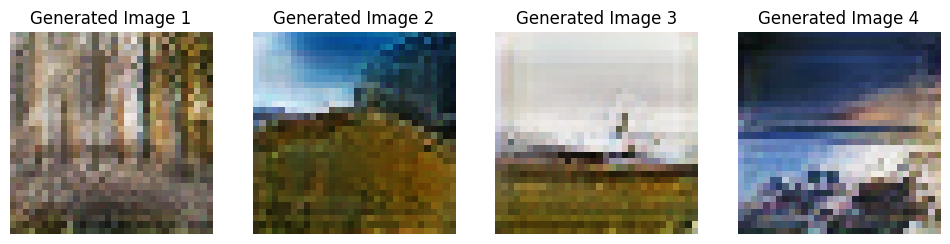

In [90]:
import matplotlib.pyplot as plt

def show_generated_images(num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    for i, real_photo in enumerate(photo_ds.take(num_images)):
        fake_monet = generator_photo2monet(real_photo, training=False).numpy()
        fake_monet = ((fake_monet + 1) * 127.5).astype(np.uint8)  

        axes[i].imshow(fake_monet[0])  
        axes[i].axis("off")
        axes[i].set_title(f"Generated Image {i+1}")

    plt.show()

show_generated_images()
